# Fake news detection

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Read datasets

In [65]:
df=pd.read_csv('train_news.csv')

In [66]:
df.shape

(20800, 6)

# Data cleaning and preparation

In [67]:
# Shuffle the data
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)

In [68]:
# Check the data
df.head()

,Unnamed: 0,id,headline,written_by,news,label
0,3757,3968,Movie About Ireland’s Win Over New Zealand Ann...,Julius Hubris,0 Add Comment \nA $250 million Hollywood block...,1
1,14943,11816,The devil you know will drag us through hell,PatriotRising,Posted 10/31/2016 12:28 pm by PatriotRising wi...,1
2,1265,8843,Verizon Announces New Name Brand for AOL and Y...,Niraj Chokshi and Vindu Goel,Oath? Oof. That was largely the reaction on Mo...,0
3,5803,14937,Election Day Sticker Shortage · Guardian Liber...,John Federico,On Election Day the enthusiasm of receiving an...,1
4,17508,8439,13 Year Old Girl’s Rousing Speech: “If Donald ...,Mac Slavo,Who can argue with this young lady’s speech?\n...,1


In [69]:
df.nunique()

Unnamed: 0    20800
id            20800
headline      19803
written_by     4201
news          20386
label             2
dtype: int64

In [70]:
# Removing the date (we won't use it for the analysis)
df.drop(["Unnamed: 0","id"],axis=1,inplace=True)
df.head()

,headline,written_by,news,label
0,Movie About Ireland’s Win Over New Zealand Ann...,Julius Hubris,0 Add Comment \nA $250 million Hollywood block...,1
1,The devil you know will drag us through hell,PatriotRising,Posted 10/31/2016 12:28 pm by PatriotRising wi...,1
2,Verizon Announces New Name Brand for AOL and Y...,Niraj Chokshi and Vindu Goel,Oath? Oof. That was largely the reaction on Mo...,0
3,Election Day Sticker Shortage · Guardian Liber...,John Federico,On Election Day the enthusiasm of receiving an...,1
4,13 Year Old Girl’s Rousing Speech: “If Donald ...,Mac Slavo,Who can argue with this young lady’s speech?\n...,1


In [71]:
df.nunique()

headline      19803
written_by     4201
news          20386
label             2
dtype: int64

In [72]:
# Removing the headline (we will only use the text)
df.drop(["headline"],axis=1,inplace=True)
df.head()

,written_by,news,label
0,Julius Hubris,0 Add Comment \nA $250 million Hollywood block...,1
1,PatriotRising,Posted 10/31/2016 12:28 pm by PatriotRising wi...,1
2,Niraj Chokshi and Vindu Goel,Oath? Oof. That was largely the reaction on Mo...,0
3,John Federico,On Election Day the enthusiasm of receiving an...,1
4,Mac Slavo,Who can argue with this young lady’s speech?\n...,1


# Check null values

In [73]:
df.isnull().sum()

written_by    1957
news            39
label            0
dtype: int64

In [74]:
df = df.fillna(' ')

In [75]:
df.isnull().sum()

written_by    0
news          0
label         0
dtype: int64

In [76]:
# Convert to lowercase

df['news'] = df['news'].apply(lambda x: x.lower())
df.head()

,written_by,news,label
0,Julius Hubris,0 add comment \na $250 million hollywood block...,1
1,PatriotRising,posted 10/31/2016 12:28 pm by patriotrising wi...,1
2,Niraj Chokshi and Vindu Goel,oath? oof. that was largely the reaction on mo...,0
3,John Federico,on election day the enthusiasm of receiving an...,1
4,Mac Slavo,who can argue with this young lady’s speech?\n...,1


In [77]:
# Remove punctuation

import string

def punctuation_removal(news):
    all_list = [char for char in news if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

df['news'] = df['news'].apply(punctuation_removal)

In [78]:
# Check
df.head(20)

,written_by,news,label
0,Julius Hubris,0 add comment \na 250 million hollywood blockb...,1
1,PatriotRising,posted 10312016 1228 pm by patriotrising with ...,1
2,Niraj Chokshi and Vindu Goel,oath oof that was largely the reaction on mond...,0
3,John Federico,on election day the enthusiasm of receiving an...,1
4,Mac Slavo,who can argue with this young lady’s speech\ni...,1
5,Jonas E. Alexis,by jonas e alexis on november 1 2016 the good ...,1
6,Ariana,first ever hindu was elected to the us house o...,1
7,noreply@blogger.com (Der Postillon),montag 14 november 2016 katastrophenschutz war...,1
8,Geoffrey Grider,desperate to ‘preserve his legacy’ barack ob...,1
9,WakingTimes,waking times \nnow that the establishment corp...,1


In [79]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['news'] = df['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rashi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
df.head(20)

,written_by,news,label
0,Julius Hubris,0 add comment 250 million hollywood blockbuste...,1
1,PatriotRising,posted 10312016 1228 pm patriotrising 0 commen...,1
2,Niraj Chokshi and Vindu Goel,oath oof largely reaction monday news reported...,0
3,John Federico,election day enthusiasm receiving voted sticke...,1
4,Mac Slavo,argue young lady’s speech bet donald trump bri...,1
5,Jonas E. Alexis,jonas e alexis november 1 2016 good thing mora...,1
6,Ariana,first ever hindu elected us house representati...,1
7,noreply@blogger.com (Der Postillon),montag 14 november 2016 katastrophenschutz war...,1
8,Geoffrey Grider,desperate ‘preserve legacy’ barack obama relea...,1
9,WakingTimes,waking times establishment corporate liberal m...,1


# Basic data exploration

In [81]:
# How many articles per subject?
print(df.groupby(['written_by'])['news'].count())

written_by
                                                                                                                          1957
# 1 NWO Hatr                                                                                                                17
-NO AUTHOR-                                                                                                                 54
10 Habits That Will Make Your Life Easier &amp; More Peaceful - Wellness Solutions                                           1
10 More Beautiful Images That Remind You We Still Live In A Beautiful World, With Beautiful People - Upside Down Media       1
                                                                                                                          ... 
تييري ميسان                                                                                                                  1
جنگ ارزی آمریکا علیه ایران / مورد مطالعاتی سال 1390 - کدآمایی                                       

label
0    10387
1    10413
Name: news, dtype: int64


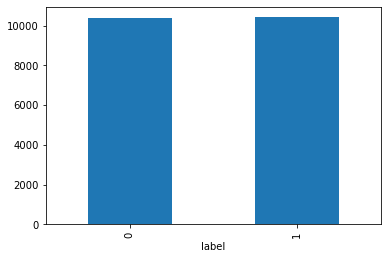

In [82]:
# How many fake and real articles?
print(df.groupby(['label'])['news'].count())
df.groupby(['label'])['news'].count().plot(kind="bar")
plt.show()

In [83]:
df.head(10)

,written_by,news,label
0,Julius Hubris,0 add comment 250 million hollywood blockbuste...,1
1,PatriotRising,posted 10312016 1228 pm patriotrising 0 commen...,1
2,Niraj Chokshi and Vindu Goel,oath oof largely reaction monday news reported...,0
3,John Federico,election day enthusiasm receiving voted sticke...,1
4,Mac Slavo,argue young lady’s speech bet donald trump bri...,1
5,Jonas E. Alexis,jonas e alexis november 1 2016 good thing mora...,1
6,Ariana,first ever hindu elected us house representati...,1
7,noreply@blogger.com (Der Postillon),montag 14 november 2016 katastrophenschutz war...,1
8,Geoffrey Grider,desperate ‘preserve legacy’ barack obama relea...,1
9,WakingTimes,waking times establishment corporate liberal m...,1


In [84]:
!pip install wordcloud

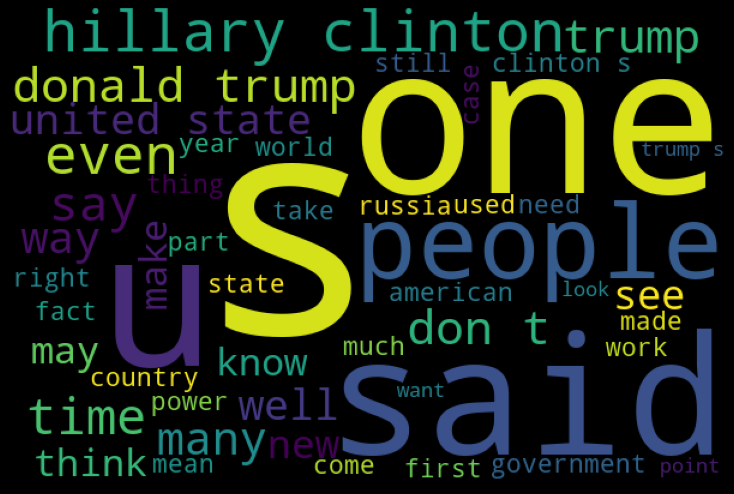

In [85]:
#Getting sense of loud words which are offensive
import wordcloud
from wordcloud import WordCloud
Fake = df['news'][df['label']==1]
Fake_News = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(Fake))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(Fake_News)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

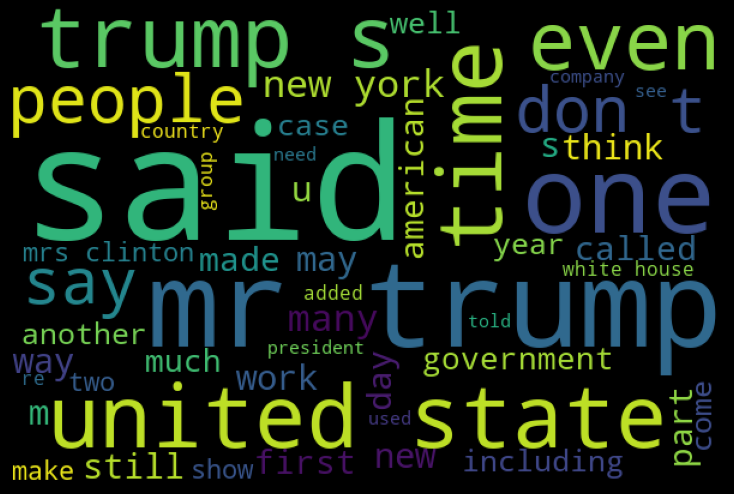

In [86]:
#Getting sense of loud words which are offensive
import wordcloud
from wordcloud import WordCloud
Fake = df['news'][df['label']==0]
Fake_News = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(Fake))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(Fake_News)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [90]:
!pip install nltk

In [91]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(df = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

In [93]:
# Most frequent words in fake news
counter(df[df["label"] == "1"], "text", 20)

KeyError: 'text'

# Tokenization

In [94]:
from nltk.tokenize import word_tokenize

In [99]:

# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Peparing the data

In [104]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(df['news'], df.label, test_size=0.2, random_state=42)

# Logistic regression

In [110]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test,prediction))

accuracy: 95.53%
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2110
           1       0.95      0.96      0.95      2050

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



Confusion matrix, without normalization


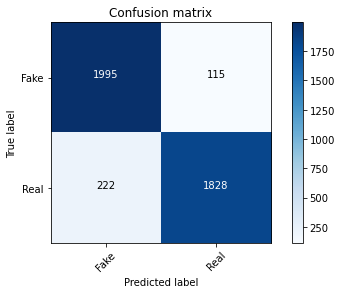

In [113]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree Classifier

In [111]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test,prediction))

accuracy: 89.57%
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2110
           1       0.89      0.90      0.90      2050

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160



Confusion matrix, without normalization


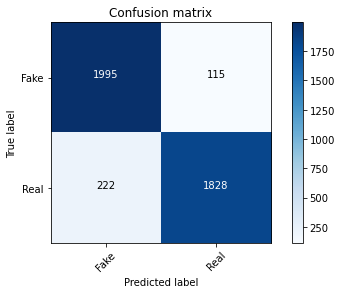

In [114]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest Classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test,prediction))

accuracy: 91.32%
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2110
           1       0.94      0.88      0.91      2050

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160



Confusion matrix, without normalization


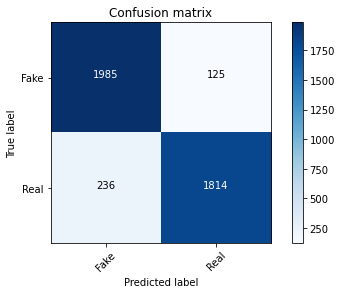

In [116]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Save the model

In [118]:
import joblib
joblib.dump(LogisticRegression,"news.pkl")

['news.pkl']